# Deep Q Network Tutorial

## 1. Environment Preparation
### 1.1 Mount drive and set project path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
project_root = '/content/drive/My Drive/DQN_tutorial/'
sys.path.append(project_root)

Mounted at /content/drive


In [ ]:
!pip install gym==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663116 sha256=df125cfaf36f13c47be153c514d05a6c97d047784e4032b1639e83ff368fd4fc
  Stored in directory: /root/.cache/pip/wheels/11/36/28/628f4dd3779e4037a6fca1aaed76827ffa4315c3ab6bfadcf6
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.2.0:
      Successfully uninstalled cloudpickle-2.2.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


### 1.2 Download Atari ROM.

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

串流輸出內容已截斷至最後 5000 行。
Extracting  /content/ROM/Acid Drop (1992) (Salu, Dennis M. Kiss) (460758) (PAL) ~.bin       1%  OK 
Extracting  /content/ROM/Action Man - Action Force (AKA G.I. Joe - Cobra Strike) (Paddle) (1983) (Parker Brothers, John Emerson) (931511) (PAL).bin       1%  OK 
Extracting  /content/ROM/Actionauts (Microbots) (1984-2008) (Imagic - Advanced Program Technology, Rob Fulop) ~.bin       1%  OK 
Extracting  /content/ROM/Activision Decathlon, The (1983) (Activision, David Crane) (AG-930-04, AZ-030) [fixed] ~.bin       1%  OK 
Extracting  /content/ROM/Activision Decathlon, The (1983) (Activision, David Crane) (AG-930-04, AZ-030) ~.bin       1%  OK 
Extracting  /content/ROM/Activision Decathlon, The (1983) (Activision, David Crane) (EAZ-030) (SECAM).bin       1%  OK 
Extracting  /content/ROM/Activision Decathlon, The - Zehnkampf (1983) (Activision, David Crane - Ariola) (EAZ-030, EAZ-030-04B, EAZ-030-04I - 711 030-725) (P

In [ ]:
import gym
print(gym.__version__)

0.19.0


## 2. Pong Game and Wrapper
### 2.1 Test the pong environment.

environment: PongNoFrameskip-v4
action space: 6
action: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space: (210, 160, 3)


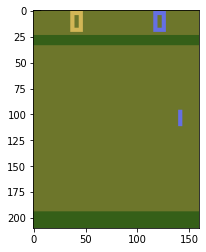

In [ ]:
import gym
import matplotlib.pyplot as plt

env_name = "PongNoFrameskip-v4"
env = gym.make(env_name)
print("environment:", env_name)
print("action space:", env.action_space.n)
print("action:", env.unwrapped.get_action_meanings())
print("observation space:", env.observation_space.shape)

state = env.reset()
action = env.action_space.sample()
state_next, reward, done, info = env.step(action)
plt.figure()
plt.imshow(state_next)

### 2.2 Environment wrapper.

In [ ]:
import numpy as np
from PIL import Image

class PongEnvWrapper(gym.Wrapper):
    def __init__(self, env, k, img_size=(84,84)):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.img_size = img_size
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(k, img_size[0], img_size[1]), dtype=np.float32)

    def _preprocess(self, state, th=0.4):
        # TODO(Lab-1): Image processing.
        state = np.array(Image.fromarray(state).resize(self.img_size,Image.BILINEAR))
        state = state.astype(np.float).mean(2) / 255.
        state[state > th] = 1.0
        state[state <=th] = 0.0
        return state

    def reset(self):
        state = self.env.reset()
        state = self._preprocess(state)
        # TODO(Lab-2): Constrct initial stacked frame.
        state = state[np.newaxis, ...].repeat(self.k, axis=0)
        return state

    def step(self, action):
        # TODO(Lab-3): Construct stacked frames.
        state_next = []
        info = []
        reward = 0
        done = False
        for i in range(self.k):
            if not done:
                state_next_f, reward_f, done_f, info_f = self.env.step(action)
                state_next_f = self._preprocess(state_next_f)
                reward += reward_f
                done = done_f
                info.append(info_f)
            state_next.append(state_next_f[np.newaxis, ...])
        state_next = np.concatenate(state_next, 0)

        return state_next, reward, done, info

observation space: (4, 84, 84)
(4, 84, 84)


<ipython-input-6-61fce146fe67>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state = state.astype(np.float).mean(2) / 255.


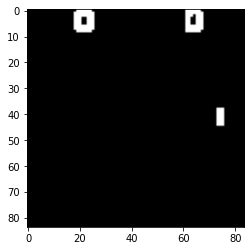

In [ ]:
# Test Code
env_pong = PongEnvWrapper(env, k=4, img_size=(84,84))
print("observation space:", env_pong.observation_space.shape)

state = env_pong.reset()
action = env_pong.action_space.sample()
state_next, reward, done, info = env_pong.step(action)
print(state_next.shape)
plt.imshow(state_next[0], cmap="gray")

## 3. Reinforcement Learning
### 3.1 Convolutional Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QNet(nn.Module):
    # TODO(Lab-4): Q-Network architecture.
    def __init__(self, input_shape, n_actions):
        super(QNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        out = self.fc(conv_out)
        return out

### 3.2 DQN Algorithm

In [ ]:
class DeepQNetwork():
    def __init__(
        self,
        n_actions,
        input_shape,
        qnet,
        device,
        learning_rate = 2e-4,
        reward_decay = 0.99,
        replace_target_iter = 1000,
        memory_size = 10000,
        batch_size = 32,
    ):
        # initialize parameters
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.device = device
        self.learn_step_counter = 0
        self.init_memory()

        # Network
        self.qnet_eval = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target.eval()
        self.optimizer = optim.RMSprop(self.qnet_eval.parameters(), lr=self.lr)

    def choose_action(self, state, epsilon=0):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        actions_value = self.qnet_eval.forward(state)
        if np.random.uniform() > epsilon:   # greedy
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()[0]
        else:   # random
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # TODO(Lab-5): DQN core algorithm.
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.qnet_target.load_state_dict(self.qnet_eval.state_dict())

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)

        b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
        b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
        b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
        b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
        b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)

        q_curr_eval = self.qnet_eval(b_s).gather(1, b_a)
        q_next_target = self.qnet_target(b_s_).detach()

        #next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN
        q_next_eval = self.qnet_eval(b_s_).detach()
        next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))   # DDQN

        q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values
        self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.learn_step_counter += 1
        return self.loss.detach().cpu().numpy()


    def init_memory(self):
        self.memory = {
            "s": np.zeros((self.memory_size, *self.input_shape)),
            "a": np.zeros((self.memory_size, 1)),
            "r": np.zeros((self.memory_size, 1)),
            "s_": np.zeros((self.memory_size, *self.input_shape)),
            "done": np.zeros((self.memory_size, 1)),
        }

    def store_transition(self, s, a, r, s_, d):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        if self.memory_counter <= self.memory_size:
            index = self.memory_counter % self.memory_size
        else:
            index = np.random.randint(self.memory_size)
        self.memory["s"][index] = s
        self.memory["a"][index] = np.array(a).reshape(-1,1)
        self.memory["r"][index] = np.array(r).reshape(-1,1)
        self.memory["s_"][index] = s_
        self.memory["done"][index] = np.array(d).reshape(-1,1)
        self.memory_counter += 1
    
    def save_load_model(self, op, path="save", fname="qnet.pt"):
        import os
        if not os.path.exists(path):
            os.makedirs(path)
        file_path = os.path.join(path, fname)
        if op == "save":
            torch.save(self.qnet_eval.state_dict(), file_path)
        elif op == "load":
            self.qnet_eval.load_state_dict(torch.load(file_path, map_location=self.device))
            self.qnet_target.load_state_dict(torch.load(file_path, map_location=self.device))

In [ ]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
        n_actions = env.action_space.n,
        input_shape = [stack_frames, *img_size],
        qnet = QNet,
        device = device,
        learning_rate = 2e-4, 
        reward_decay = 0.99,
        replace_target_iter = 1000, 
        memory_size = 10000,
        batch_size = 32,)

print(agent.qnet_eval)

QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)


## 4. Training and testing process.
### 4.1 Play the game.

In [ ]:
def play(env, agent, stack_frames, img_size):
    # Reset environment.
    state = env.reset()
    img_buffer = [Image.fromarray(state[0]*255)]

    # Initialize information.
    step = 0
    total_reward = 0

    # One episode.
    while True:
        # Select action.
        action = agent.choose_action(state, 0)

        # Get next stacked state.
        state_next, reward, done, info = env.step(action)
        if step % 2 == 0:
            img_buffer.append(Image.fromarray(state_next[0]*255))

        state = state_next.copy()
        step += 1
        total_reward += reward
        print('\rStep: {:3d} | Reward: {:.3f} / {:.3f}'\
            .format(step, reward, total_reward), end="")
            
        if done or step>2000:
            print()
            break

    return img_buffer

In [ ]:
import os
def save_gif(img_buffer, fname, gif_path=os.path.join(project_root, "gif")):
    if not os.path.exists(gif_path):
        os.makedirs(gif_path)
    img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=1, loop=0)

In [ ]:
# Test Code
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test.gif")

<ipython-input-6-61fce146fe67>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state = state.astype(np.float).mean(2) / 255.


Step: 764 | Reward: -1.000 / -21.000


### 4.2 Epsilon greedy computation.

In [ ]:
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.05, epsilon_decay=100000):
    return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

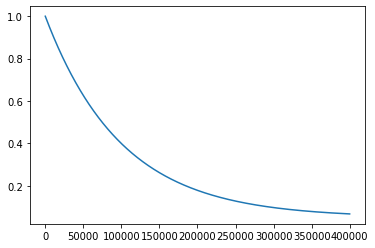

In [ ]:
# Test Code
frame_ids = np.array(range(400000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)

### 4.3 Training steps.

In [ ]:
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=1000000):
    total_step = 0
    episode = 0
    while True:
        # Reset environment.
        state = env.reset()

        # Initialize information.
        step = 0
        total_reward = 0
        loss = 0

        # One episode.
        while True:
            # TODO(Lab-6): Select action.
            # Select action.
            epsilon = epsilon_compute(total_step)
            action = agent.choose_action(state, epsilon)

            # Get next stacked state.
            state_next, reward, done, info = env.step(action)

            # TODO(Lab-7): Train RL model.
            # Store transition and learn.
            agent.store_transition(state, action, reward, state_next, done)
            if total_step > 4*agent.batch_size:
                loss = agent.learn()

            state = state_next.copy()
            step += 1
            total_step += 1
            total_reward += reward

            if total_step % 100 == 0 or done:
                print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
                    .format(episode, step, total_step, reward, total_reward, loss, epsilon), end="")
            
            if total_step % 10000 == 0:
                print("\nSave Model ...")
                agent.save_load_model(op="save", path=save_path, fname="qnet.pt")
                print("Generate GIF ...")
                img_buffer = play(env, agent, stack_frames, img_size)
                save_gif(img_buffer, "train_" + str(total_step).zfill(6) + ".gif")
                print("Done !!")

            if done or step>2000:
                episode += 1
                print()
                break
        
        if total_step > max_steps:
            break

In [ ]:
train(env_pong, agent, stack_frames, img_size, save_path=os.path.join(project_root, "save"), max_steps=400000)

<ipython-input-6-61fce146fe67>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state = state.astype(np.float).mean(2) / 255.


Episode:   0 | Step: 990 / 990 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.991
Episode:   1 | Step: 940 / 1930 | Reward: -1.000 / -21.000 | Loss: 0.001 | Epsilon: 0.982
Episode:   2 | Step: 1072 / 3002 | Reward: -1.000 / -19.000 | Loss: 0.000 | Epsilon: 0.972
Episode:   3 | Step: 783 / 3785 | Reward: -1.000 / -21.000 | Loss: 0.001 | Epsilon: 0.965
Episode:   4 | Step: 951 / 4736 | Reward: -1.000 / -19.000 | Loss: 0.015 | Epsilon: 0.956
Episode:   5 | Step: 1026 / 5762 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.947
Episode:   6 | Step: 1072 / 6834 | Reward: -1.000 / -19.000 | Loss: 0.000 | Epsilon: 0.937
Episode:   7 | Step: 1100 / 7934 | Reward: -1.000 / -20.000 | Loss: 0.001 | Epsilon: 0.928
Episode:   8 | Step: 871 / 8805 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.920
Episode:   9 | Step: 960 / 9765 | Reward: -1.000 / -20.000 | Loss: 0.000 | Epsilon: 0.912
Episode:  10 | Step: 235 / 10000 | Reward: 0.000 / -5.000 | Loss: 0.000 | Epsilon: 0.910
Save Mod

### 4.4 Evaluate the trained model.

In [ ]:
agent.save_load_model(op="load", path=os.path.join(project_root, "save"), fname="qnet.pt")
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, "eval.gif")

<ipython-input-6-61fce146fe67>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state = state.astype(np.float).mean(2) / 255.


Step: 1637 | Reward: 1.000 / 21.000


In [ ]:
!python train.py --batch 32 --epochs 100 --data{dataset.location}/data.yaml --weights playing_card_detection_6.pt --cache -freeze 10